In [1]:
import pandas
import datetime
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
%pylab inline

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/scipy/cluster/vq.py:88: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _vq
/usr/local/lib/python2.7/dist-packages/scipy/cluster/hierarchy.py:178: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _hierarchy
/usr/local/lib/python2.7/dist-packages/sklearn/utils/__init__.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32


In [2]:
fName = "/home/bharat/Documents/code/sson_pred/data/20190103-22-53-substorms.csv"

In [3]:
smssDF = pandas.read_csv(fName, parse_dates=["Date_UTC"])
# rename the cols
smssDF.columns = [ "datetime", "mlat", "mlt" ]
smssDF.head()

,datetime,mlat,mlt
0,1996-01-01 20:16:00,71.32,22.45
1,1996-01-01 23:36:00,70.23,0.07
2,1996-01-02 00:25:00,69.36,22.92
3,1996-01-02 14:12:00,70.06,23.20
4,1996-01-02 16:09:00,65.81,0.62


In [4]:
# Calculate the time diff between two consecutive SS
# onsets in each of the DFs
smlDelTime = smssDF["datetime"].diff()
# convert the difference to minutes
smlDelTime = smlDelTime.apply(\
                lambda x: x.total_seconds()/60. )

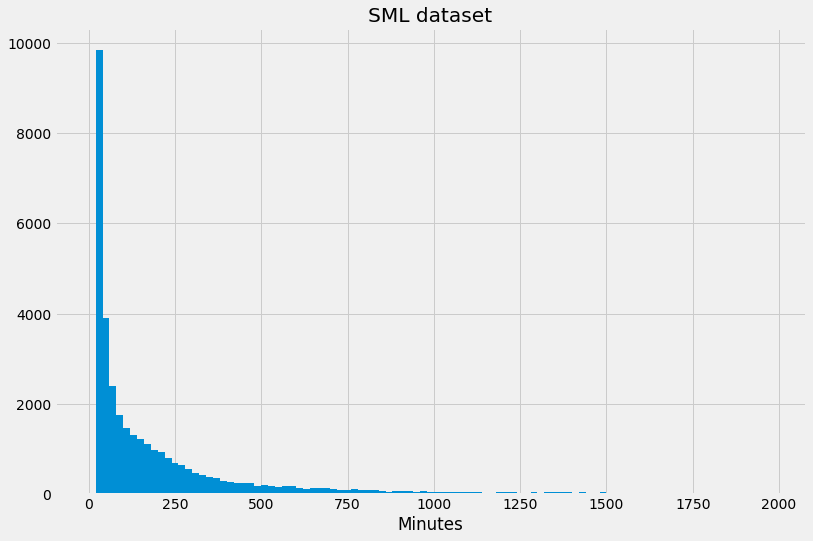

In [5]:
bins = range(0,2000,20)#[0,10,20,40,60,120,240,2400]

plt.style.use("fivethirtyeight")
f = plt.figure(figsize=(12, 8))

ax1 = f.add_subplot(1,1,1)

hist = ax1.hist(smlDelTime.values[1:], bins=bins)

# ax1.set_xlim(0,24)
ax1.set_title("SML dataset")
ax1.set_xlabel("Minutes")


f.savefig( "../plots/delT-hist-sml.pdf",bbox_inches='tight' )

In [6]:
# print hist[0]
# print hist[1]

In [16]:
cutOff = 60
blwCutoff = 0
abvCutoff = 0
for _c,_b in zip(hist[0], hist[1]):
    if _b <= cutOff:
        print _b, _c
        blwCutoff += _c
    else:
        abvCutoff += _c
print "cutOff", cutOff
print "blwCutoff", blwCutoff
print "abvCutoff", abvCutoff

0 0.0
20 9840.0
40 3914.0
60 2404.0
cutOff 60
blwCutoff 16158.0
abvCutoff 19099.0


In [13]:
print sum(hist[0]), smlDelTime.min(), smlDelTime.max(), smlDelTime.median()

35257.0 20.0 18404.0 102.0
